In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score, top_k_accuracy_score
import matplotlib.pyplot as plt


In [2]:
print(torch.__version__)

2.3.0+cu121


In [3]:
# 数据加载和预处理
class MovieLensDataset(Dataset):
    def __init__(self, users, items, ratings):
        self.users = users
        self.items = items
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

def load_data(file_path):
    df = pd.read_csv(file_path)
    # 确保 user_id 和 movie_id 从 1 开始连续编号
    user_map = {user: idx + 1 for idx, user in enumerate(df['user_id'].unique())}
    movie_map = {movie: idx + 1 for idx, movie in enumerate(df['movie_id'].unique())}
    df['user_id'] = df['user_id'].map(user_map)
    df['movie_id'] = df['movie_id'].map(movie_map)
    
    user_item_pairs = df[['user_id', 'movie_id']].values
    ratings = df['imdbId'].values / 5.0  #使用实际的评分值，评分范围为0到5，将其标准化到0到1
    train_pairs, test_pairs, train_ratings, test_ratings = train_test_split(user_item_pairs, ratings, test_size=0.2, random_state=42)
    train_dataset = MovieLensDataset(torch.LongTensor(train_pairs[:, 0]), torch.LongTensor(train_pairs[:, 1]), torch.FloatTensor(train_ratings))
    test_dataset = MovieLensDataset(torch.LongTensor(test_pairs[:, 0]), torch.LongTensor(test_pairs[:, 1]), torch.FloatTensor(test_ratings))
    
    return DataLoader(train_dataset, batch_size=256, shuffle=True), DataLoader(test_dataset, batch_size=256, shuffle=False), df


In [4]:
# GMF模型
class GMF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim):
        super(GMF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.output_layer = nn.Linear(latent_dim, 1)
    
    def forward(self, user, item):
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        element_product = user_embedding * item_embedding
        return torch.sigmoid(self.output_layer(element_product))

In [5]:
# MLP模型
class MLP(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, layers):
        super(MLP, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.layers = nn.Sequential()
        input_dim = 2 * latent_dim
        for i, layer_size in enumerate(layers):
            self.layers.add_module(f"layer_{i}", nn.Linear(input_dim, layer_size))
            self.layers.add_module(f"relu_{i}", nn.ReLU())
            input_dim = layer_size
        self.output_layer = nn.Linear(input_dim, 1)

    def forward(self, user, item):
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        concatenated = torch.cat([user_embedding, item_embedding], dim=-1)
        return torch.sigmoid(self.output_layer(self.layers(concatenated)))
        #return self.output_layer(concatenated)

def MLP_with_hidden_layers(num_users, num_items, latent_dim, num_hidden_layers):
    layers = [latent_dim] * num_hidden_layers  # 创建一个大小为 num_hidden_layers 的列表，每个元素为 latent_dim
    return MLP(num_users, num_items, latent_dim, layers)

In [6]:
# NeuMF模型
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, layers):
        super(NeuMF, self).__init__()
        self.gmf_user_embedding = nn.Embedding(num_users, latent_dim)
        self.gmf_item_embedding = nn.Embedding(num_items, latent_dim)
        self.mlp_user_embedding = nn.Embedding(num_users, latent_dim)
        self.mlp_item_embedding = nn.Embedding(num_items, latent_dim)
        self.mlp_layers = nn.Sequential()
        input_dim = 2 * latent_dim
        for i, layer_size in enumerate(layers):
            self.mlp_layers.add_module(f"layer_{i}", nn.Linear(input_dim, layer_size))
            self.mlp_layers.add_module(f"relu_{i}", nn.ReLU())
            input_dim = layer_size
        self.output_layer = nn.Linear(input_dim + latent_dim, 1)
    
    def forward(self, user, item):
        gmf_user_embedding = self.gmf_user_embedding(user)
        gmf_item_embedding = self.gmf_item_embedding(item)
        gmf_output = gmf_user_embedding * gmf_item_embedding
        
        mlp_user_embedding = self.mlp_user_embedding(user)
        mlp_item_embedding = self.mlp_item_embedding(item)
        mlp_concatenated = torch.cat([mlp_user_embedding, mlp_item_embedding], dim=-1)
        mlp_output = self.mlp_layers(mlp_concatenated)
        
        concatenated = torch.cat([gmf_output, mlp_output], dim=-1)
        return torch.sigmoid(self.output_layer(concatenated))


In [7]:
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    model.train()
    epoch_hr_10_list, epoch_ndcg_10_list = [], []
    for epoch in range(num_epochs):
        total_loss = 0
        for user, item, rating in train_loader:
            optimizer.zero_grad()
            prediction = model(user - 1, item - 1)  # Subtract 1 to match the embedding indices
            loss = criterion(prediction.squeeze(), rating)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate after each epoch and store HR@10 and NDCG@10
        hr_10, ndcg_10 = evaluate(model, test_loader)
        epoch_hr_10_list.append(hr_10)
        epoch_ndcg_10_list.append(ndcg_10)
        
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}, HR@10: {hr_10}, NDCG@10: {ndcg_10}")

    return epoch_hr_10_list, epoch_ndcg_10_list

def evaluate(model, test_loader, k=10):
    model.eval()
    hr_10_list = []
    ndcg_10_list = []
    
    with torch.no_grad():
        for user, item, rating in test_loader:
            prediction = model(user - 1, item - 1)  # Subtract 1 to match the embedding indices
            prediction = prediction.squeeze().cpu().numpy()
            rating = rating.cpu().numpy()

            # Sort predicted scores and get the top K items
            sorted_indices = np.argsort(-prediction)
            top_k_indices = sorted_indices[:k]
            
            # Compute HR@10
            hr_10 = np.isin(top_k_indices, np.where(rating == 1)[0]).sum() / len(top_k_indices)
            hr_10_list.append(hr_10)

            # Compute NDCG@10
            ideal_sorted_indices = np.argsort(-rating)
            ideal_top_k = rating[ideal_sorted_indices[:k]]
            ideal_dcg = (2 ** ideal_top_k - 1) / np.log2(np.arange(1, k + 1) + 1)
            dcg = (2 ** rating[top_k_indices] - 1) / np.log2(np.arange(1, k + 1) + 1)
            ndcg_10 = dcg.sum() / ideal_dcg.sum()
            ndcg_10_list.append(ndcg_10)
    
    return np.mean(hr_10_list), np.mean(ndcg_10_list)

def plot_metrics(metrics_dict, metric_name):
    plt.figure(figsize=(10, 5))
    for model_name, metric_values in metrics_dict.items():
        epochs = range(1, len(metric_values) + 1)
        plt.plot(epochs, metric_values, label=model_name)
    plt.title(f'{metric_name} vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()


Training GMF...
Epoch 1, Loss: 0.614730857288845, HR@10: 0.23235294117647062, NDCG@10: 0.6651028372072654
Epoch 2, Loss: 0.5962908765061574, HR@10: 0.2347826086956522, NDCG@10: 0.6680268221560292
Epoch 3, Loss: 0.5962882766491774, HR@10: 0.22813299232736578, NDCG@10: 0.6660230068138624
Epoch 4, Loss: 0.5962587648565313, HR@10: 0.2240409207161125, NDCG@10: 0.6549932189391464
Epoch 5, Loss: 0.596164116741981, HR@10: 0.21662404092071608, NDCG@10: 0.6525264492709514
Epoch 6, Loss: 0.595904392267143, HR@10: 0.22979539641943733, NDCG@10: 0.6616963036292206
Epoch 7, Loss: 0.5951628091429871, HR@10: 0.2722506393861892, NDCG@10: 0.6853052709888877
Epoch 8, Loss: 0.5930107683992051, HR@10: 0.34859335038363165, NDCG@10: 0.7359383635598012
Epoch 9, Loss: 0.5878584106725069, HR@10: 0.44181585677749363, NDCG@10: 0.7948733197387733
Epoch 10, Loss: 0.5801734828216787, HR@10: 0.5276214833759592, NDCG@10: 0.8404278337594577
Epoch 11, Loss: 0.5726001848986877, HR@10: 0.5873401534526853, NDCG@10: 0.868565

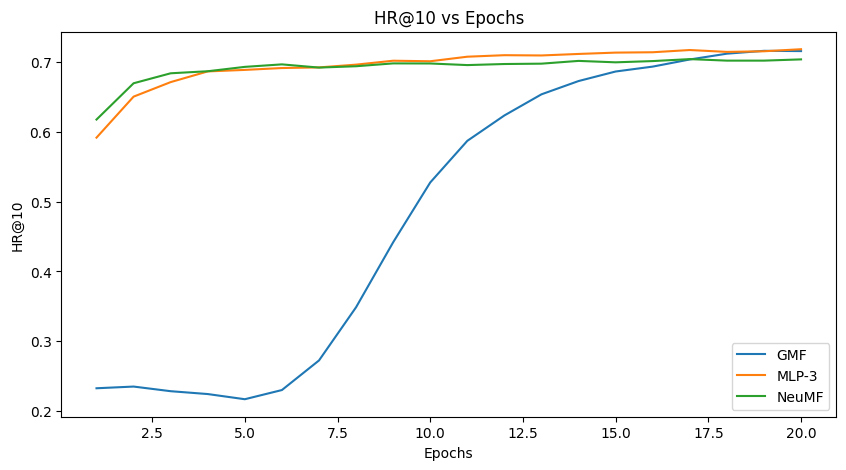

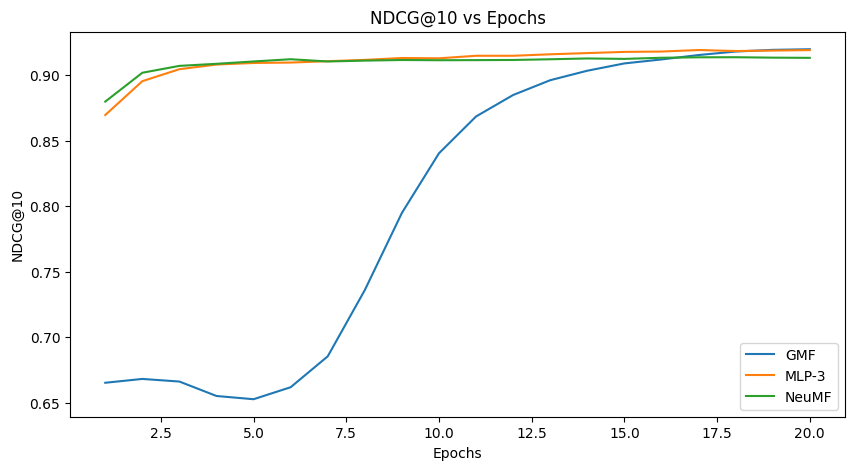

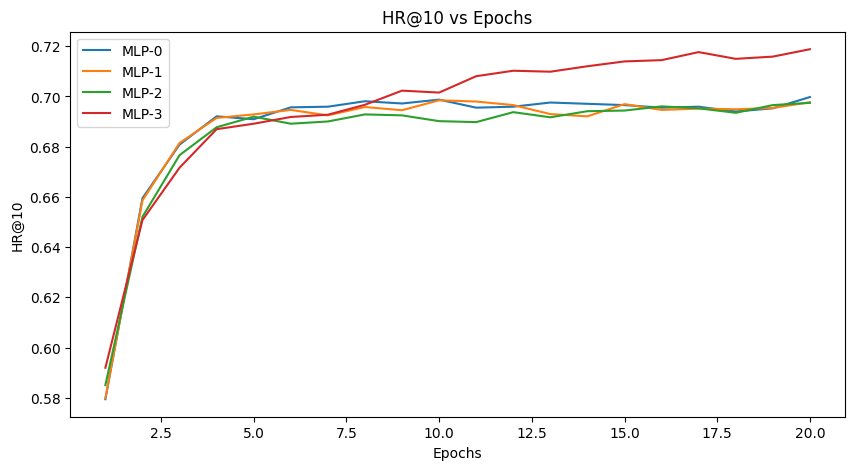

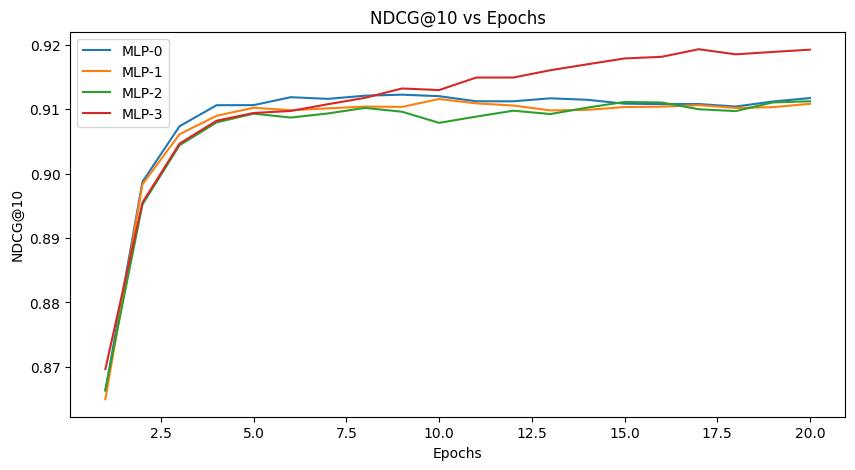

In [8]:
# 主函数
def main():
    file_path = 'movies_ratings_user.csv'  # 请确保文件路径正确
    train_loader, test_loader, df = load_data(file_path)
    num_users = df['user_id'].nunique() + 1  # 因为 user_id 从 1 开始
    num_items = df['movie_id'].nunique() + 1  # 因为 movie_id 从 1 开始
    latent_dim = 8
    layers = [64, 32, 16, 8]
    num_epochs = 20
    learning_rate = 0.001

    models = {
        "GMF": GMF(num_users, num_items, latent_dim),
        "MLP-0": MLP_with_hidden_layers(num_users, num_items, latent_dim, 0),
        "MLP-1": MLP_with_hidden_layers(num_users, num_items, latent_dim, 1),
        "MLP-2": MLP_with_hidden_layers(num_users, num_items, latent_dim, 2),
        "MLP-3": MLP_with_hidden_layers(num_users, num_items, latent_dim, 3),
        "NeuMF": NeuMF(num_users, num_items, latent_dim, layers)
    }
    
    # Initialize dictionaries to store HR@10 and NDCG@10 for each model
    hr_10_dict_group1 = {}
    ndcg_10_dict_group1 = {}
    hr_10_dict_group2 = {}
    ndcg_10_dict_group2 = {}

    for model_name, model in models.items():
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print(f"Training {model_name}...")
        epoch_hr_10_list, epoch_ndcg_10_list = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)
        #hr_10_dict[model_name] = epoch_hr_10_list
        #ndcg_10_dict[model_name] = epoch_ndcg_10_list
        if model_name in ["GMF", "MLP-3", "NeuMF"]:
            hr_10_dict_group1[model_name] = epoch_hr_10_list
            ndcg_10_dict_group1[model_name] = epoch_ndcg_10_list
        if model_name in ["MLP-0", "MLP-1", "MLP-2", "MLP-3"]:
            hr_10_dict_group2[model_name] = epoch_hr_10_list
            ndcg_10_dict_group2[model_name] = epoch_ndcg_10_list

        
    # Plot HR@10 and NDCG@10 for all models
    plot_metrics(hr_10_dict_group1, 'HR@10')
    plot_metrics(ndcg_10_dict_group1, 'NDCG@10')
    
    plot_metrics(hr_10_dict_group2, 'HR@10')
    plot_metrics(ndcg_10_dict_group2, 'NDCG@10')

if __name__ == "__main__":
    main()